# Extract VisitTables-visit Results in  OGA

 work with Weakly_2023_44
- use jupyter kernel LSST
- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2024/01/01
- update : 2023/01/01


In [1]:
! eups list -s | grep LOCAL

analysis_tools        LOCAL:/home/d/dagoret/repos/repos_w_2023_44/analysis_tools 	setup
atmospec              LOCAL:/home/d/dagoret/repos/repos_w_2023_44/atmospec 	setup
eups                  LOCAL:/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/eups 	setup
spectractor           LOCAL:/home/d/dagoret/repos/repos_w_2023_44/Spectractor 	setup


In [2]:
! eups list -s lsst_distrib

   g4213664e8e+d053631def 	current w_2023_44 setup


In [3]:
import lsst.daf.butler as dafButler
#import lsst.summit.utils.butlerUtils as butlerUtils

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm


import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.io import fits

import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import pickle

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [5]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.time import Time


In [6]:
# LSST Display
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

In [7]:
transform = AsinhStretch() + PercentileInterval(99.)

In [8]:
pd.options.display.max_columns = None
#pd.options.display.max_rows = None



## Configuration

In [9]:
filesource_out="ccdVisitTable_202312.csv"
#filetractpatch_out = 'Latiss_tractspatchs_202312.pickle'

In [10]:
#repo =  "/sdf/group/rubin/repo/main"
repo = "/sdf/group/rubin/repo/oga/"
butler = dafButler.Butler(repo)
registry = butler.registry

In [11]:
def get_corners_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    corners_ra, corners_dec in decimal degrees
    """

    corners_x = [bbox.beginX, bbox.beginX, bbox.endX, bbox.endX]
    corners_y = [bbox.beginY, bbox.endY, bbox.endY, bbox.beginY]
    corners_ra = []
    corners_dec = []
    for i in range(4):
        radec = wcs.pixelToSky(corners_x[i], corners_y[i])
        corners_ra.append(radec.getRa().asDegrees())
        corners_dec.append(radec.getDec().asDegrees())
    
    return corners_ra, corners_dec

In [12]:
def get_bbox_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    ramin,ramax,decmin,decmax in decimal degrees
    """

    xmin = bbox.beginX
    xmax = bbox.endX
    ymin = bbox.beginY
    ymax = bbox.endY
    
    radec_ll = wcs.pixelToSky(xmin, ymin)
    radec_ur = wcs.pixelToSky(xmax, ymax)
        
    return radec_ur.getRa().asDegrees(),radec_ll.getRa().asDegrees(), radec_ll.getDec().asDegrees(),radec_ur.getDec().asDegrees() 

In [13]:
def isradec_inbbox_radec(ra,dec,wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    ra: ra in degree
    dec: dec in degree
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    Bool
    
    """

    RAMIN,RAMAX,DECMIN,DECMAX = get_bbox_radec(wcs, bbox)

    assert RAMIN < RAMAX
    assert DECMIN < DECMAX

    flag = (ra >= RAMIN) and (ra<=RAMAX) and (dec>= DECMIN) and (dec <= DECMAX) 
    return flag

## Give the collection

In [14]:
my_collection = "LATISS/runs/AUXTEL_DRP_IMAGING_2023-11A-10A-09AB-08ABC-07AB-05AB/w_2023_46/PREOPS-4553"

In [15]:
skymap_auxtel ='latiss_v1'
skymap = butler.get('skyMap', skymap=skymap_auxtel, collections=my_collection)

## Config

In [16]:
Auxtel2023_tracts = [ 5616,5634,5615,10644,383,8188,3863,455,452,5839,10643,382]

In [17]:
with open('Latiss_tractspatchs.pickle', 'rb') as handle:
    tracts_patchs_dict = pickle.load(handle)

In [18]:
tract_selected = 5615
patches_selected = [294,313]
suptitle = f"CCD visit in tract {tract_selected} and patches {patches_selected[0]} and {patches_selected[1]}"

### Find tract

In [19]:
for tractInfo in skymap:
    tractID = tractInfo.getId()
    if tractID == tract_selected:
        break

In [20]:
tractInfo

TractInfo(id=5615, ctrCoord=[-0.4548159976772596, -0.7877644160721412, -0.4154150130018864])

In [21]:
# WCS for this patch
tWCS=tractInfo.getWcs()

### Find patches

In [22]:
all_patches = []
for patch in tractInfo:
    patchID = patch.getSequentialIndex()
    if patchID in patches_selected:
        all_patches.append(patch)        

In [23]:
all_patches

[PatchInfo(index=Index2D(x=9, y=15), innerBBox=(minimum=(27000, 45000), maximum=(29999, 47999)), outerBBox=(minimum=(26800, 44800), maximum=(30199, 48199)), cellInnerDimensions=(150, 150), cellBorder=50, numCellsPerPatchInner=22),
 PatchInfo(index=Index2D(x=9, y=16), innerBBox=(minimum=(27000, 48000), maximum=(29999, 50999)), outerBBox=(minimum=(26800, 47800), maximum=(30199, 51199)), cellInnerDimensions=(150, 150), cellBorder=50, numCellsPerPatchInner=22)]

In [24]:
for patch in all_patches:
    patchID = patch.getSequentialIndex()
    ibb=patch.getInnerBBox()
    print("patch ",patchID,"ibb=",ibb)
    RAMIN,RAMAX,DECMIN,DECMAX = get_bbox_radec(tWCS, ibb)

patch  294 ibb= (minimum=(27000, 45000), maximum=(29999, 47999))
patch  313 ibb= (minimum=(27000, 48000), maximum=(29999, 50999))


# Sources

In [25]:
datasetRefs = butler.registry.queryDatasets(datasetType='ccdVisitTable', collections=my_collection, where= "instrument='LATISS'")

In [26]:
for i, ref in enumerate(datasetRefs):
   
    print("========================datasetType = ccdVisitTable ============================================")
    print("fullId..................:",ref.dataId.full)
    

========================datasetType = ccdVisitTable ============================================
fullId..................: {instrument: 'LATISS'}


In [27]:
visit_table = butler.get('visitTable', dataId={'instrument': 'LATISS', 'detector': 0}, collections = my_collection )    
visit_table

,visit,physical_filter,band,ra,dec,decl,skyRotation,azimuth,altitude,zenithDistance,airmass,expTime,expMidpt,expMidptMJD,obsStart,obsStartMJD
visitId,,,,,,,,,,,,,,,,
2023051100262,2023051100262,SDSSr_65mm~empty,r,239.941279,-24.050861,-24.050861,322.911701,100.652699,33.079204,56.920796,1.826588,30.0,2023-05-12 01:08:56.302993,60076.047874,2023-05-12 01:08:41.302993,60076.047700
2023051100263,2023051100263,SDSSg_65mm~empty,g,239.943099,-24.042851,-24.042851,170.005077,100.427273,33.535722,56.464278,1.804276,30.0,2023-05-12 01:11:06.209005,60076.049377,2023-05-12 01:10:51.209005,60076.049204
2023051100264,2023051100264,SDSSi_65mm~empty,i,239.940919,-24.040927,-24.040927,170.004955,100.024337,34.385246,55.614754,1.765315,30.0,2023-05-12 01:15:04.912000,60076.052140,2023-05-12 01:14:49.912000,60076.051967
2023051100268,2023051100268,SDSSr_65mm~empty,r,239.960079,-24.042010,-24.042010,323.867206,99.573769,35.343223,54.656777,1.724092,30.0,2023-05-12 01:19:39.311494,60076.055316,2023-05-12 01:19:24.311494,60076.055142
2023051100270,2023051100270,SDSSi_65mm~empty,i,239.963850,-24.048746,-24.048746,170.004124,99.285576,35.972240,54.027760,1.697680,30.0,2023-05-12 01:22:36.150002,60076.057363,2023-05-12 01:22:21.150002,60076.057189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023110800361,2023110800361,SDSSr_65mm~empty,r,12.484554,-72.844660,-72.844660,0.005046,190.808106,45.321169,44.678831,1.404020,30.0,2023-11-09 04:07:51.959003,60257.172129,2023-11-09 04:07:36.959003,60257.171956
2023110800362,2023110800362,empty~SDSSi_65mm,i,12.484284,-72.844676,-72.844676,0.005577,190.880555,45.287851,44.712149,1.404812,30.0,2023-11-09 04:08:40.330495,60257.172689,2023-11-09 04:08:25.330495,60257.172515
2023110800364,2023110800364,SDSSr_65mm~empty,r,12.534375,-72.844687,-72.844687,0.005419,191.029053,45.218513,44.781487,1.406498,30.0,2023-11-09 04:10:33.961007,60257.174004,2023-11-09 04:10:18.961007,60257.173831


In [28]:
ccd_visit_table = butler.get('ccdVisitTable', dataId={'instrument': 'LATISS', 'detector': 0}, collections = my_collection )    
ccd_visit_table

,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,decl,detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
40919696896,2023051100262,SDSSr_65mm~empty,r,239.946727,-24.053746,56.749516,27.705477,7.776608,11.197219,7.856582,0.032861,0.019685,39,-0.004245,-0.001485,0.031742,0.014841,0.089763,0.063628,0.008093,0.659493,1402.701904,-24.053746,0,1.752650,322.911701,2023-05-12 01:08:56.302993,60076.047874,30.0,2023-05-12 01:08:41.302993,60076.047700,30.2434,4071,3999,239.935566,-24.128925,240.029264,-24.062574,239.957874,-23.978566,239.864200,-24.044873
40919697152,2023051100263,SDSSg_65mm~empty,g,239.941335,-24.038380,56.289413,27.909496,7.784901,3.989901,7.472743,0.032879,0.018671,20,0.012385,0.007139,0.029436,0.042836,0.158896,0.171208,0.021377,5.179351,2200.962158,-24.038380,0,1.754600,170.005077,2023-05-12 01:11:06.209005,60076.049377,30.0,2023-05-12 01:10:51.209005,60076.049204,30.2343,4071,3999,239.988740,-23.976092,239.872262,-23.996196,239.893883,-24.100653,240.010453,-24.080532
40919697408,2023051100264,SDSSi_65mm~empty,i,239.938163,-24.036848,55.439133,27.848541,6.357665,28.071854,8.586543,0.026557,0.017523,35,0.012835,-0.013177,0.020933,0.046253,-0.012802,0.100489,0.015865,0.367621,1484.087036,-24.036848,0,1.432899,170.004955,2023-05-12 01:15:04.912000,60076.052140,30.0,2023-05-12 01:14:49.912000,60076.051967,30.2335,4071,3999,239.985572,-23.974553,239.869113,-23.994653,239.890709,-24.099128,240.007259,-24.079011
40919698432,2023051100268,SDSSr_65mm~empty,r,239.964413,-24.045511,54.482189,27.753105,8.100518,10.701076,7.854048,0.026480,0.014894,32,-0.001825,-0.007242,0.012690,0.015632,0.152651,0.114754,0.013798,0.492981,2023.047119,-24.045511,0,1.825550,323.867206,2023-05-12 01:19:39.311494,60076.055316,30.0,2023-05-12 01:19:24.311494,60076.055142,30.2379,4071,3999,239.951868,-24.120504,240.046768,-24.055597,239.976943,-23.970518,239.882070,-24.035382
40919698944,2023051100270,SDSSi_65mm~empty,i,239.961137,-24.046364,53.849277,27.852003,6.746165,23.952093,8.440446,0.023563,0.012609,34,-0.011282,0.003969,0.037771,0.022550,-0.016428,0.143892,0.020965,1.172336,1726.039673,-24.046364,0,1.520463,170.004124,2023-05-12 01:22:36.150002,60076.057363,30.0,2023-05-12 01:22:21.150002,60076.057189,30.2424,4071,3999,240.008536,-23.984061,239.892087,-24.004162,239.913693,-24.108652,240.030233,-24.088535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42438060288,2023110800361,SDSSr_65mm~empty,r,12.472362,-72.844737,44.729496,27.849432,5.733940,7.405540,8.019971,0.021888,0.013789,56,-0.009452,-0.008703,0.024639,0.027964,-0.085554,0.168348,0.029979,0.591626,1244.262451,-72.844737,0,1.292204,0.005046,2023-11-09 04:07:51.959003,60257.172129,30.0,2023-11-09 04:07:36.959003,60257.171956,30.2341,4071,3999,12.290521,-72.898489,12.658600,-72.897144,12.653100,-72.790823,12.287227,-72.792161
42438060544,2023110800362,empty~SDSSi_65mm,i,12.473520,-72.844725,44.762394,27.866249,5.811111,17.281977,8.557647,0.021350,0.014090,60,0.001978,-0.005822,0.018680,0.019454,0.027814,0.122145,0.020740,0.656929,1039.071899,-72.844725,0,1.309372,0.005577,2023-11-09 04:08:40.330495,60257.172689,30.0,2023-11-09 04:08:25.330495,60257.172515,30.2311,4071,3999,12.291749,-72.898464,12.659756,-72.897129,12.654188,-72.790824,12.288386,-72.792152
42438061056,2023110800364,SDSSr_65mm~empty,r,12.522335,-72.844696,44.832893,27.825552,5.680949,7.506320,8.040755,0.022361,0.013507,52,-0.000942,-0.019654,0.014277,0.034852,-0.040949,0.

### Compute datetime to plot vs time

In [29]:
ccd_visit_table["Time"] = pd.to_datetime(ccd_visit_table['obsStart'])

#### Compute airmass

In [30]:
ccd_visit_table["airmass"] = ccd_visit_table["zenithDistance"].apply(lambda x: 1/np.cos(np.pi/180.*x))

## Find those visits in the selected tract and patches

### Patch 293 and 313

In [31]:
def SelectVisits(row):
    try:
        ra = row["ra"]
        dec = row["dec"]
        selectFlag = False
        for patch in all_patches:
            patchID = patch.getSequentialIndex()
            ibb=patch.getInnerBBox()
            flag = isradec_inbbox_radec(ra,dec,tWCS, ibb)
            selectFlag =  selectFlag or flag
        return selectFlag
    except Exception as inst:
        print(type(inst))    # the exception type
        print(inst.args)     # arguments stored in .args
        print(inst)          # __str__ allows args to be printed directly,
        return False
        

In [32]:
ccd_visit_table1 = ccd_visit_table
ccd_visit_table1["selectFlag"] = ccd_visit_table1.apply(SelectVisits, axis=1, raw=False)

In [33]:
ccd_visit_table_selected1 = ccd_visit_table1[ccd_visit_table1["selectFlag"]]

In [34]:
ccd_visit_table_selected1.drop(["selectFlag"],axis=1,inplace=True) 

/tmp/ipykernel_8464/3288211684.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccd_visit_table_selected1.drop(["selectFlag"],axis=1,inplace=True)


In [35]:
ccd_visit_table_selected1.columns

Index(['visitId', 'physical_filter', 'band', 'ra', 'dec', 'zenithDistance',
       'zeroPoint', 'psfSigma', 'skyBg', 'skyNoise', 'astromOffsetMean',
       'astromOffsetStd', 'nPsfStar', 'psfStarDeltaE1Median',
       'psfStarDeltaE2Median', 'psfStarDeltaE1Scatter',
       'psfStarDeltaE2Scatter', 'psfStarDeltaSizeMedian',
       'psfStarDeltaSizeScatter', 'psfStarScaledDeltaSizeScatter',
       'psfTraceRadiusDelta', 'maxDistToNearestPsf', 'decl', 'detector',
       'seeing', 'skyRotation', 'expMidpt', 'expMidptMJD', 'expTime',
       'obsStart', 'obsStartMJD', 'darkTime', 'xSize', 'ySize', 'llcra',
       'llcdec', 'ulcra', 'ulcdec', 'urcra', 'urcdec', 'lrcra', 'lrcdec',
       'Time', 'airmass'],
      dtype='object')

In [36]:
df = ccd_visit_table_selected1

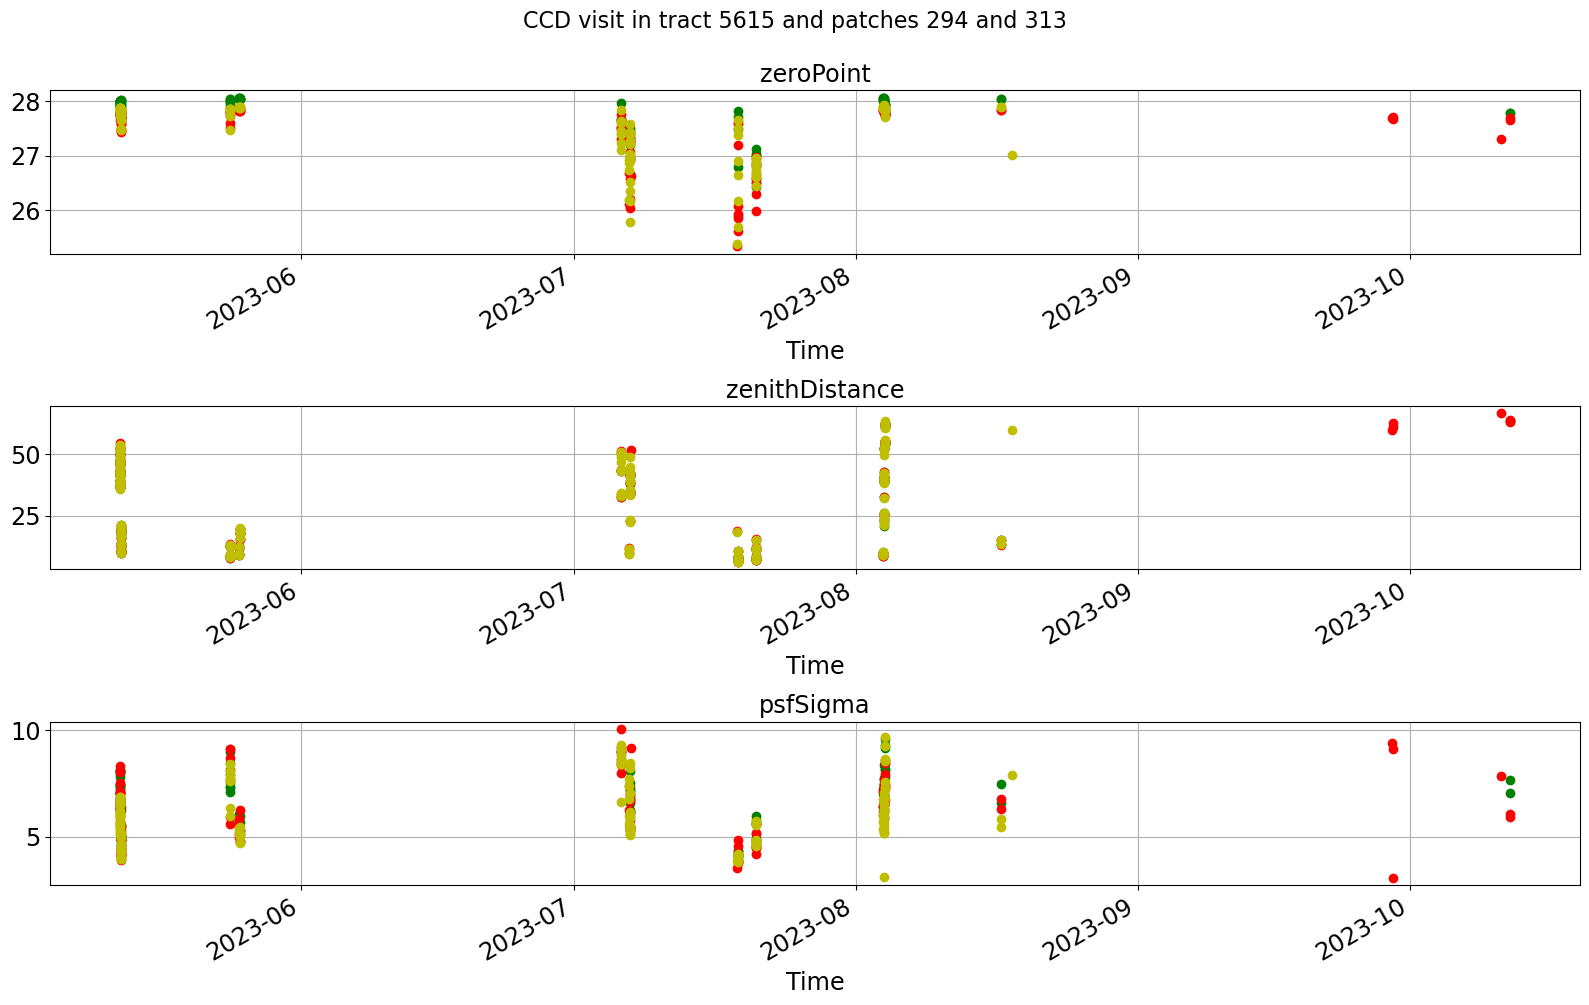

In [37]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(16,10))

df[df["band"]=="g"].plot(x="Time",y="zeroPoint",marker='o',c="g",lw=0.0,ax=ax1,grid=True,legend=False)
df[df["band"]=="r"].plot(x="Time",y="zeroPoint",marker='o',c="r",lw=0.0,ax=ax1,grid=True,legend=False)
df[df["band"]=="i"].plot(x="Time",y="zeroPoint",marker='o',c="y",lw=0.0,ax=ax1,grid=True,legend=False)
ax1.set_title("zeroPoint")


df[df["band"]=="g"].plot(x="Time",y="zenithDistance",marker='o',c="g",lw=0.0,ax=ax2,grid=True,legend=False)
df[df["band"]=="r"].plot(x="Time",y="zenithDistance",marker='o',c="r",lw=0.0,ax=ax2,grid=True,legend=False)
df[df["band"]=="i"].plot(x="Time",y="zenithDistance",marker='o',c="y",lw=0.0,ax=ax2,grid=True,legend=False)
ax2.set_title("zenithDistance")

df[df["band"]=="g"].plot(x="Time",y="psfSigma",marker='o',c="g",lw=0.0,ax=ax3,grid=True,legend=False)
df[df["band"]=="r"].plot(x="Time",y="psfSigma",marker='o',c="r",lw=0.0,ax=ax3,grid=True,legend=False)
df[df["band"]=="i"].plot(x="Time",y="psfSigma",marker='o',c="y",lw=0.0,ax=ax3,grid=True,legend=False)
ax3.set_title("psfSigma")

#df.plot(x="Time",y="coord_dec",marker='o',c="g",lw=0.0,ax=ax2,grid=True)
plt.suptitle(suptitle,y=1.0,fontsize=16)
plt.tight_layout()

### Zero point in patch 294

In [38]:
patches_selected = [294]
suptitle = f"CCD visit in tract {tract_selected} and patches {patches_selected[0]}"

In [39]:
all_patches = []
for patch in tractInfo:
    patchID = patch.getSequentialIndex()
    if patchID in patches_selected:
        all_patches.append(patch)        

In [40]:
ccd_visit_table2 = ccd_visit_table
ccd_visit_table2["selectFlag"] = ccd_visit_table2.apply(SelectVisits, axis=1, raw=False)
ccd_visit_table_selected2 = ccd_visit_table2[ccd_visit_table2["selectFlag"]]
ccd_visit_table_selected2.drop(["selectFlag"],axis=1,inplace=True) 
df = ccd_visit_table_selected2

/tmp/ipykernel_8464/1300792257.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccd_visit_table_selected2.drop(["selectFlag"],axis=1,inplace=True)


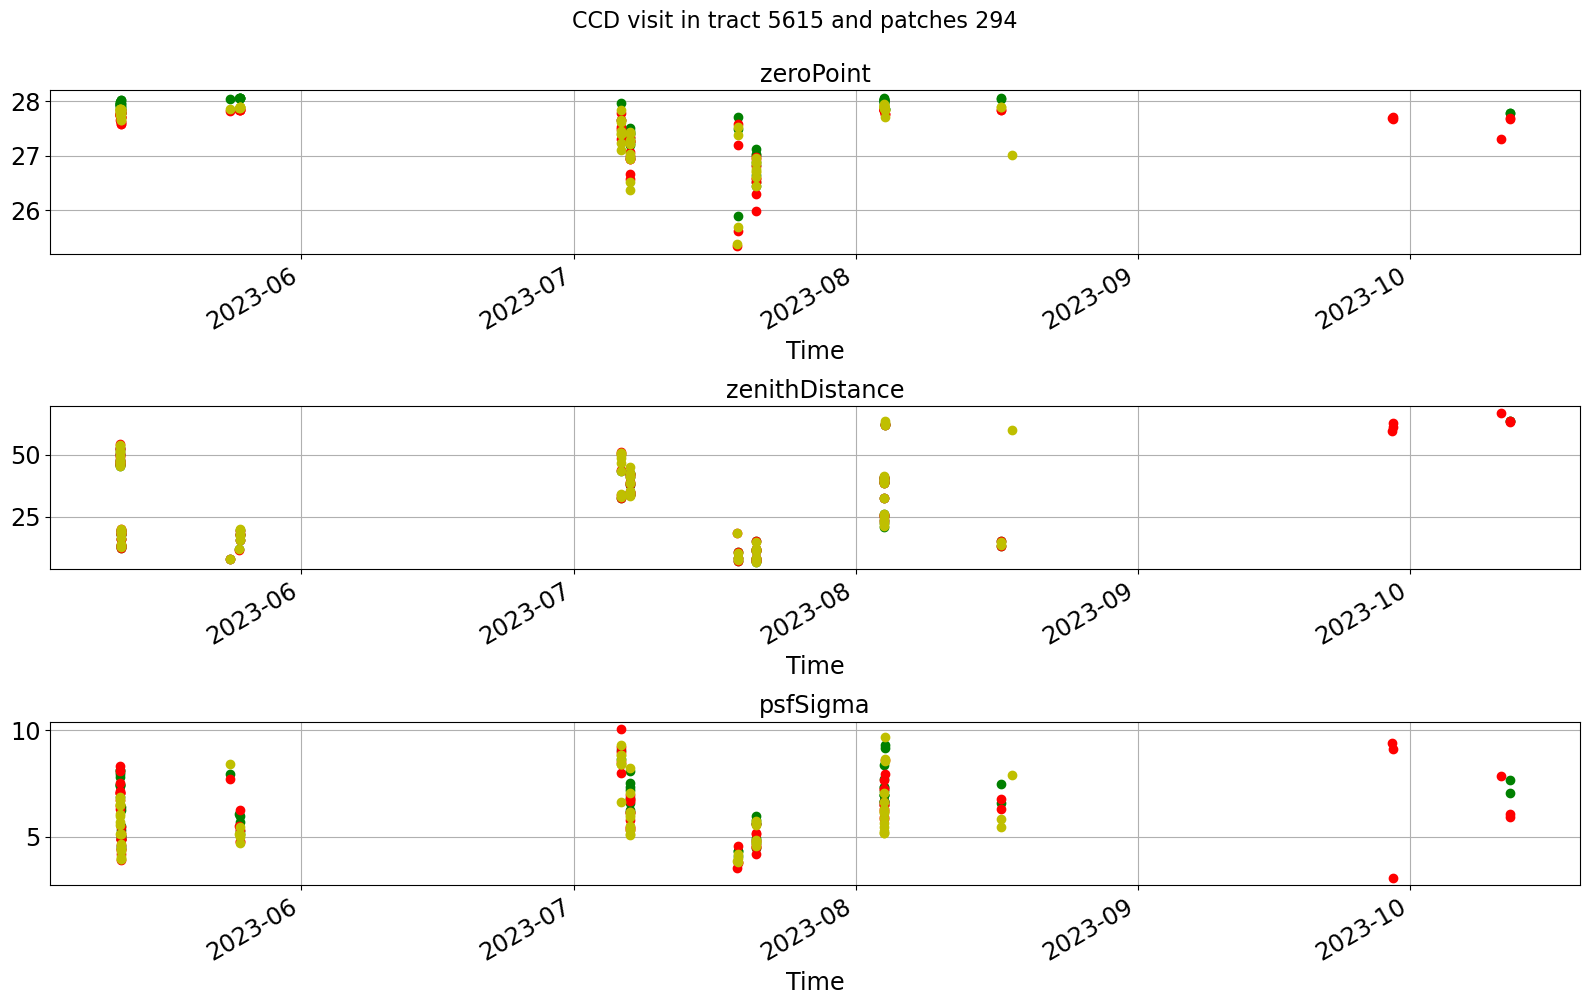

In [41]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(16,10))

df[df["band"]=="g"].plot(x="Time",y="zeroPoint",marker='o',c="g",lw=0.0,ax=ax1,grid=True,legend=False)
df[df["band"]=="r"].plot(x="Time",y="zeroPoint",marker='o',c="r",lw=0.0,ax=ax1,grid=True,legend=False)
df[df["band"]=="i"].plot(x="Time",y="zeroPoint",marker='o',c="y",lw=0.0,ax=ax1,grid=True,legend=False)
ax1.set_title("zeroPoint")

df[df["band"]=="g"].plot(x="Time",y="zenithDistance",marker='o',c="g",lw=0.0,ax=ax2,grid=True,legend=False)
df[df["band"]=="r"].plot(x="Time",y="zenithDistance",marker='o',c="r",lw=0.0,ax=ax2,grid=True,legend=False)
df[df["band"]=="i"].plot(x="Time",y="zenithDistance",marker='o',c="y",lw=0.0,ax=ax2,grid=True,legend=False)
ax2.set_title("zenithDistance")

df[df["band"]=="g"].plot(x="Time",y="psfSigma",marker='o',c="g",lw=0.0,ax=ax3,grid=True,legend=False)
df[df["band"]=="r"].plot(x="Time",y="psfSigma",marker='o',c="r",lw=0.0,ax=ax3,grid=True,legend=False)
df[df["band"]=="i"].plot(x="Time",y="psfSigma",marker='o',c="y",lw=0.0,ax=ax3,grid=True,legend=False)
ax3.set_title("psfSigma")

#df.plot(x="Time",y="coord_dec",marker='o',c="g",lw=0.0,ax=ax2,grid=True)
plt.suptitle(suptitle,y=1.0,fontsize=16)
plt.tight_layout()

### Zero point in patch 313

In [42]:
patches_selected = [313]
suptitle = f"CCD visit in tract {tract_selected} and patches {patches_selected[0]}"

In [43]:
all_patches = []
for patch in tractInfo:
    patchID = patch.getSequentialIndex()
    if patchID in patches_selected:
        all_patches.append(patch)  

In [44]:
ccd_visit_table3 = ccd_visit_table
ccd_visit_table3["selectFlag"] = ccd_visit_table3.apply(SelectVisits, axis=1, raw=False)
ccd_visit_table_selected3 = ccd_visit_table3[ccd_visit_table3["selectFlag"]]
ccd_visit_table_selected3.drop(["selectFlag"],axis=1,inplace=True) 
df = ccd_visit_table_selected3

/tmp/ipykernel_8464/1768213705.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccd_visit_table_selected3.drop(["selectFlag"],axis=1,inplace=True)


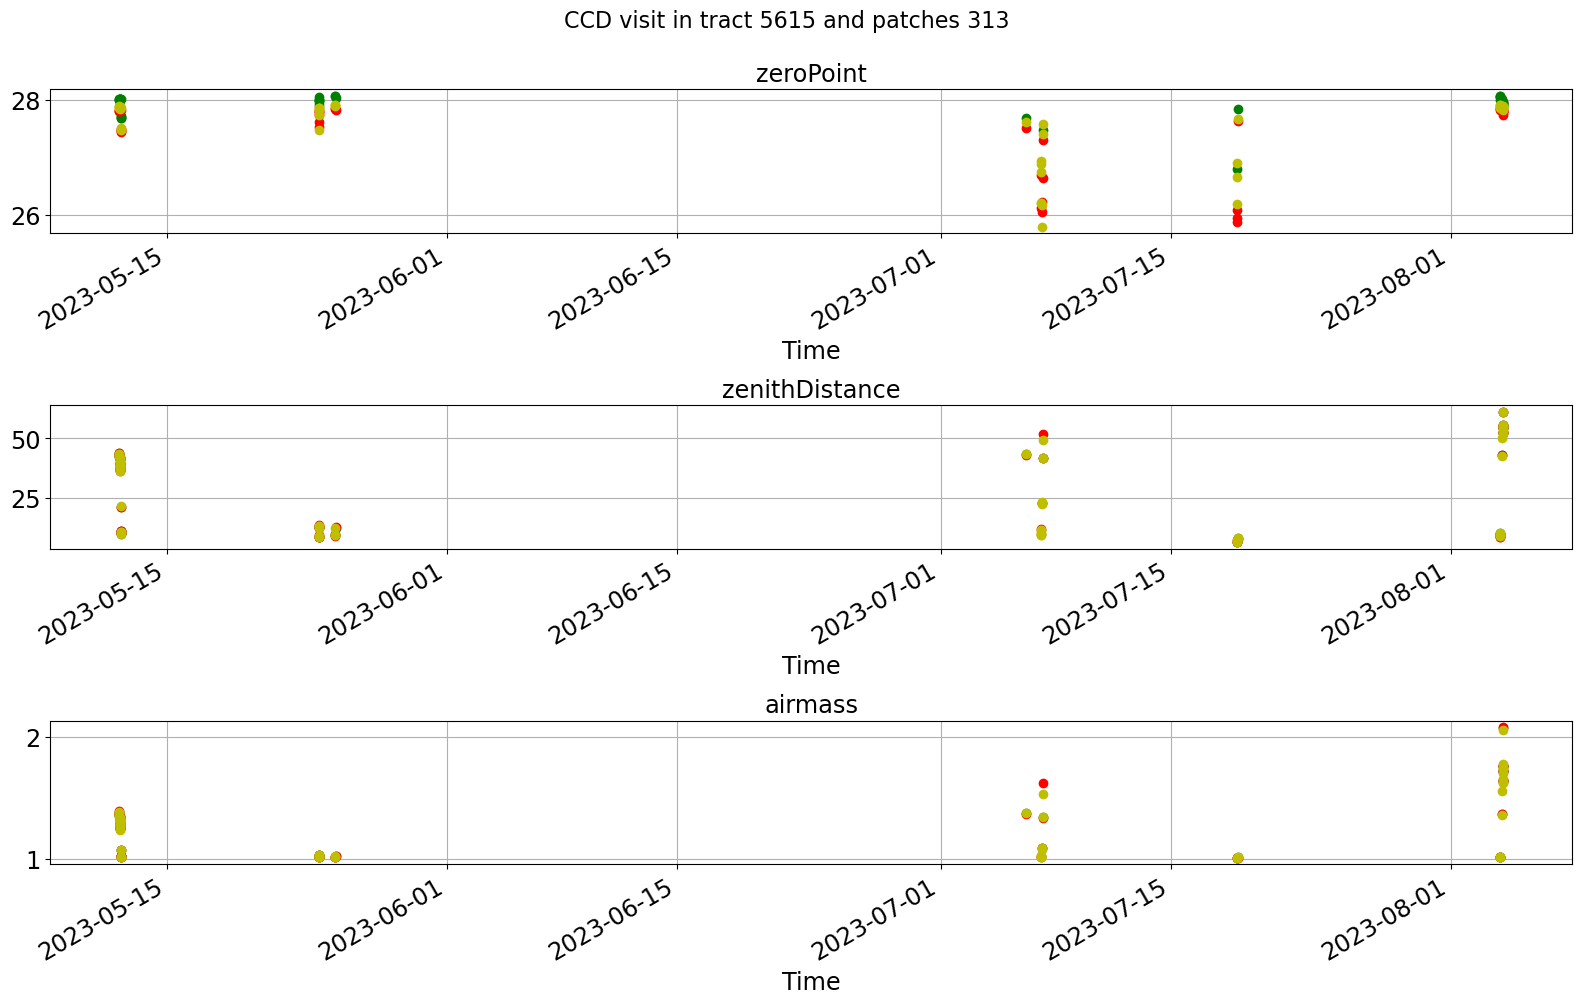

In [45]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(16,10))

df[df["band"]=="g"].plot(x="Time",y="zeroPoint",marker='o',c="g",lw=0.0,ax=ax1,grid=True,legend=False)
df[df["band"]=="r"].plot(x="Time",y="zeroPoint",marker='o',c="r",lw=0.0,ax=ax1,grid=True,legend=False)
df[df["band"]=="i"].plot(x="Time",y="zeroPoint",marker='o',c="y",lw=0.0,ax=ax1,grid=True,legend=False)
ax1.set_title("zeroPoint")

df[df["band"]=="g"].plot(x="Time",y="zenithDistance",marker='o',c="g",lw=0.0,ax=ax2,grid=True,legend=False)
df[df["band"]=="r"].plot(x="Time",y="zenithDistance",marker='o',c="r",lw=0.0,ax=ax2,grid=True,legend=False)
df[df["band"]=="i"].plot(x="Time",y="zenithDistance",marker='o',c="y",lw=0.0,ax=ax2,grid=True,legend=False)
ax2.set_title("zenithDistance")

df[df["band"]=="g"].plot(x="Time",y="airmass",marker='o',c="g",lw=0.0,ax=ax3,grid=True,legend=False)
df[df["band"]=="r"].plot(x="Time",y="airmass",marker='o',c="r",lw=0.0,ax=ax3,grid=True,legend=False)
df[df["band"]=="i"].plot(x="Time",y="airmass",marker='o',c="y",lw=0.0,ax=ax3,grid=True,legend=False)
ax3.set_title("airmass")

#df.plot(x="Time",y="coord_dec",marker='o',c="g",lw=0.0,ax=ax2,grid=True)
plt.suptitle(suptitle,y=1.0,fontsize=16)
plt.tight_layout()

## Plot number of visit per day

### Plot number of visit per day for patch 294

In [46]:
patches_selected = [294]
suptitle = f"CCD visit in tract {tract_selected} and patches {patches_selected[0]}"

In [47]:
all_patches = []
for patch in tractInfo:
    patchID = patch.getSequentialIndex()
    if patchID in patches_selected:
        all_patches.append(patch)        

In [48]:
ccd_visit_table1 = ccd_visit_table
ccd_visit_table1["selectFlag"] = ccd_visit_table1.apply(SelectVisits, axis=1, raw=False)

In [49]:
ccd_visit_table1["dayobsMJD"]=ccd_visit_table1["obsStartMJD"].apply(np.int64)

In [50]:
ccd_visit_table1.sort_values(by=['dayobsMJD',"obsStartMJD"])

,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,decl,detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,Time,airmass,selectFlag,dayobsMJD
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
40919696896,2023051100262,SDSSr_65mm~empty,r,239.946727,-24.053746,56.749516,27.705477,7.776608,11.197219,7.856582,0.032861,0.019685,39,-0.004245,-0.001485,0.031742,0.014841,0.089763,0.063628,0.008093,0.659493,1402.701904,-24.053746,0,1.752650,322.911701,2023-05-12 01:08:56.302993,60076.047874,30.0,2023-05-12 01:08:41.302993,60076.047700,30.2434,4071,3999,239.935566,-24.128925,240.029264,-24.062574,239.957874,-23.978566,239.864200,-24.044873,2023-05-12 01:08:41.302993,1.823818,False,60076
40919697152,2023051100263,SDSSg_65mm~empty,g,239.941335,-24.038380,56.289413,27.909496,7.784901,3.989901,7.472743,0.032879,0.018671,20,0.012385,0.007139,0.029436,0.042836,0.158896,0.171208,0.021377,5.179351,2200.962158,-24.038380,0,1.754600,170.005077,2023-05-12 01:11:06.209005,60076.049377,30.0,2023-05-12 01:10:51.209005,60076.049204,30.2343,4071,3999,239.988740,-23.976092,239.872262,-23.996196,239.893883,-24.100653,240.010453,-24.080532,2023-05-12 01:10:51.209005,1.801808,False,60076
40919697408,2023051100264,SDSSi_65mm~empty,i,239.938163,-24.036848,55.439133,27.848541,6.357665,28.071854,8.586543,0.026557,0.017523,35,0.012835,-0.013177,0.020933,0.046253,-0.012802,0.100489,0.015865,0.367621,1484.087036,-24.036848,0,1.432899,170.004955,2023-05-12 01:15:04.912000,60076.052140,30.0,2023-05-12 01:14:49.912000,60076.051967,30.2335,4071,3999,239.985572,-23.974553,239.869113,-23.994653,239.890709,-24.099128,240.007259,-24.079011,2023-05-12 01:14:49.912000,1.762794,False,60076
40919698432,2023051100268,SDSSr_65mm~empty,r,239.964413,-24.045511,54.482189,27.753105,8.100518,10.701076,7.854048,0.026480,0.014894,32,-0.001825,-0.007242,0.012690,0.015632,0.152651,0.114754,0.013798,0.492981,2023.047119,-24.045511,0,1.825550,323.867206,2023-05-12 01:19:39.311494,60076.055316,30.0,2023-05-12 01:19:24.311494,60076.055142,30.2379,4071,3999,239.951868,-24.120504,240.046768,-24.055597,239.976943,-23.970518,239.882070,-24.035382,2023-05-12 01:19:24.311494,1.721301,True,60076
40919698944,2023051100270,SDSSi_65mm~empty,i,239.961137,-24.046364,53.849277,27.852003,6.746165,23.952093,8.440446,0.023563,0.012609,34,-0.011282,0.003969,0.037771,0.022550,-0.016428,0.143892,0.020965,1.172336,1726.039673,-24.046364,0,1.520463,170.004124,2023-05-12 01:22:36.150002,60076.057363,30.0,2023-05-12 01:22:21.150002,60076.057189,30.2424,4071,3999,240.008536,-23.984061,239.892087,-24.004162,239.913693,-24.108652,240.030233,-24.088535,2023-05-12 01:22:21.150002,1.695170,True,60076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42438060288,2023110800361,SDSSr_65mm~empty,r,12.472362,-72.844737,44.729496,27.849432,5.733940,7.405540,8.019971,0.021888,0.013789,56,-0.009452,-0.008703,0.024639,0.027964,-0.085554,0.168348,0.029979,0.591626,1244.262451,-72.844737,0,1.292204,0.005046,2023-11-09 04:07:51.959003,60257.172129,30.0,2023-11-09 04:07:36.959003,60257.171956,30.2341,4071,3999,12.290521,-72.898489,12.658600,-72.897144,12.653100,-72.790823,12.287227,-72.792161,2023-11-09 04:07:36.959003,1.407584,False,60257
42438060544,2023110800362,empty~SDSSi_65mm,i,12.473520,-72.844725,44.762394,27.866249,5.811111,17.281977,8.557647,0.021350,0.014090,60,0.001978,-0.005822,0.018680,0.019454,0.027814,0.122145,0.020740,0.656929,1039.071899,-72.844725,0,1.309372,0.005577,2023-11-09 04:08:40.330495,6025

In [51]:
#ccd_visit_table1.sort_values(by=['dayobsMJD']).count()
ccd_visit_table_counts = ccd_visit_table1.groupby(['dayobsMJD','band']).count()["visitId"]

In [52]:
type(ccd_visit_table_counts)

pandas.core.series.Series

In [53]:
ccd_visit_table_counts.name='counts'
ccd_visit_table_counts

dayobsMJD  band
60076      g       52
           i       54
           r       54
60088      g       13
           i       13
                   ..
60256      i       11
           r        9
60257      g       13
           i       16
           r       18
Name: counts, Length: 62, dtype: int64

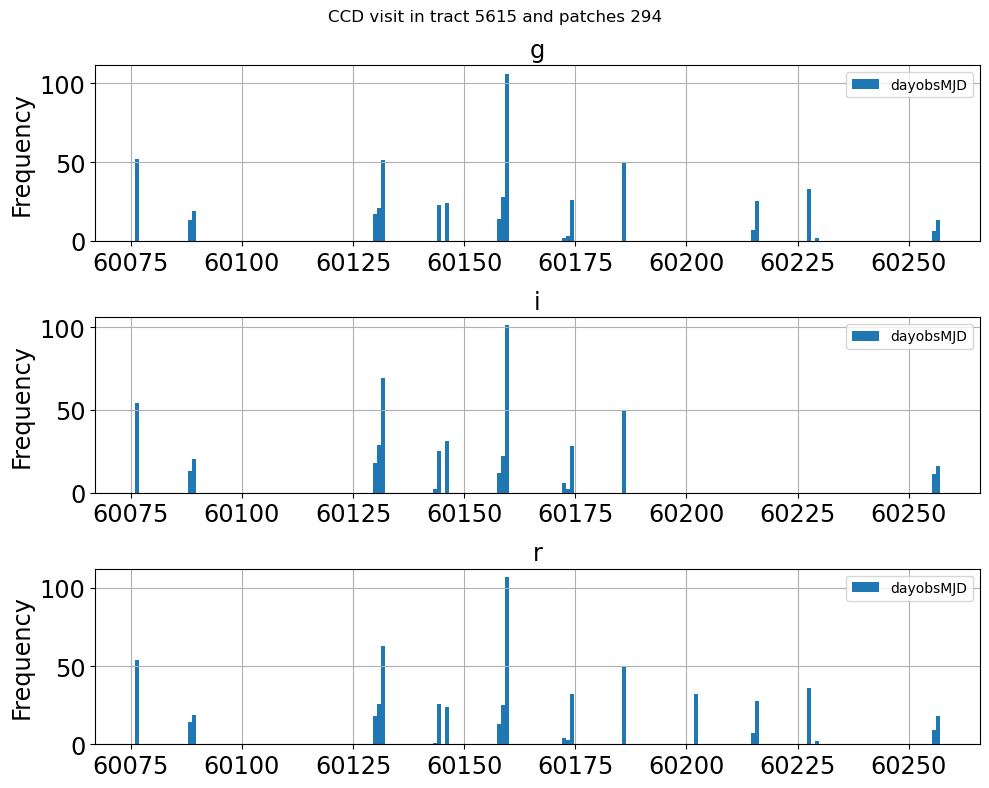

In [54]:
ccd_visit_table1.plot.hist(column=["dayobsMJD"], by="band", bins=200,figsize=(10, 8),grid=True,label=False)
plt.suptitle(suptitle)
plt.tight_layout()


In [55]:
ccd_visit_table1['dayobsMJD'].max() - ccd_visit_table1['dayobsMJD'].min()

181

In [56]:
ccd_visit_table1['nightObs'] =ccd_visit_table1.apply(lambda x: x['visitId']//100_000, axis=1)

In [57]:
ccd_visit_table1['nightObs'].min()

20230511

In [58]:
ccd_visit_table1['nightObs'].max()

20231108

/tmp/ipykernel_8464/931854703.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  ccd_visit_table1.plot.hist(column=["nightObs"], by="band", bins=200,grid=True,ax=ax,legend=False)


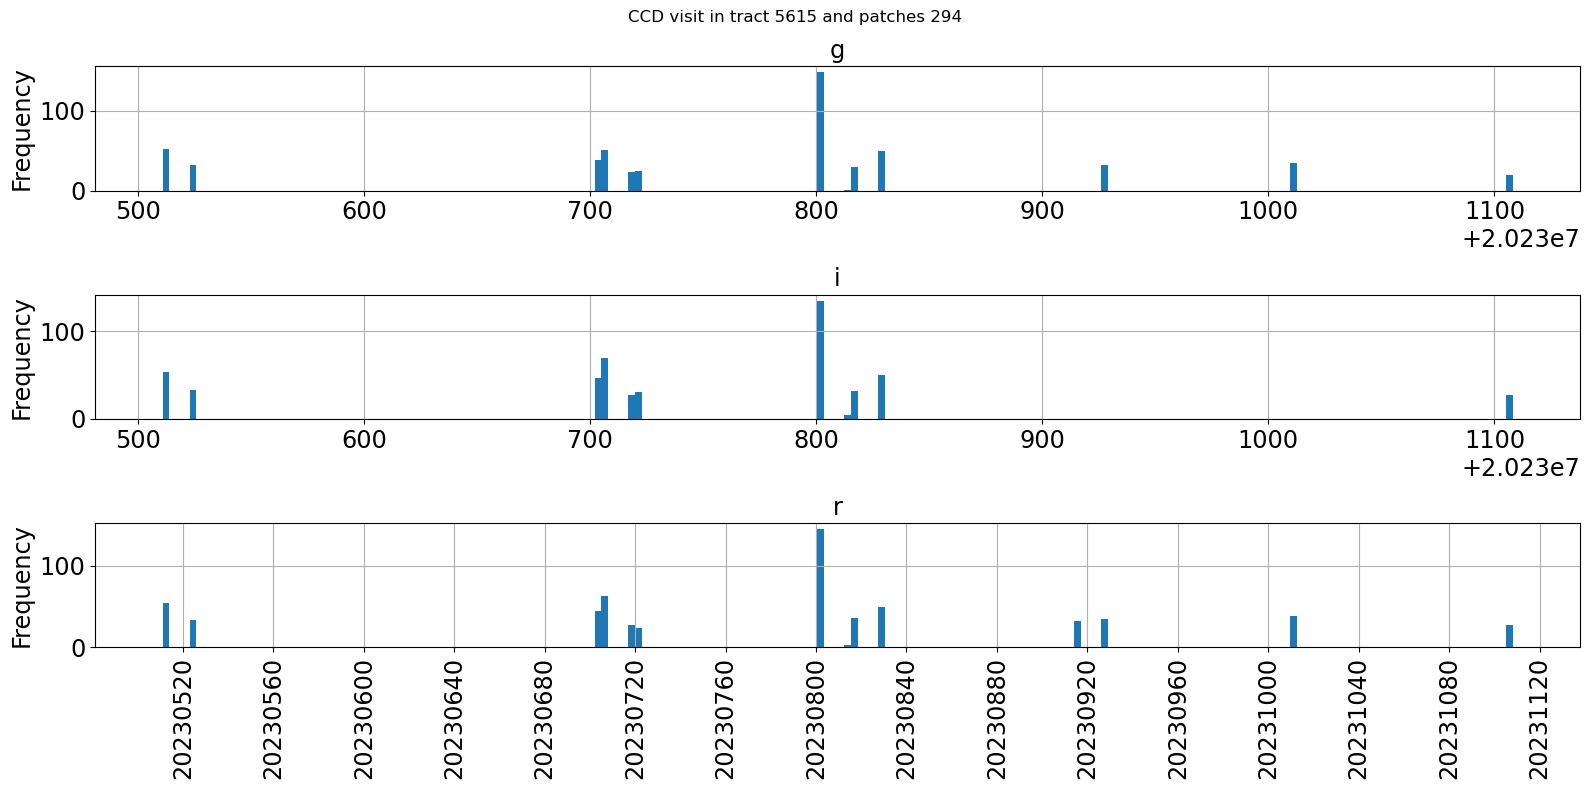

In [59]:

import matplotlib.ticker
fig,ax = plt.subplots(1,1,figsize=(16,8))
ccd_visit_table1.plot.hist(column=["nightObs"], by="band", bins=200,grid=True,ax=ax,legend=False)


# plot x axis as an int
locator = matplotlib.ticker.MultipleLocator(2)

plt.gca().xaxis.set_major_locator(locator)
formatter = matplotlib.ticker.StrMethodFormatter("{x:.0f}")
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
plt.xticks(rotation=90)

plt.suptitle(suptitle)
plt.tight_layout()

In [60]:
ccd_visit_table_counts1 = ccd_visit_table1.groupby(['nightObs','band']).count()["visitId"]
ccd_visit_table_counts1

nightObs  band
20230511  g        52
          i        54
          r        54
20230523  g        13
          i        13
          r        14
20230524  g        19
          i        20
          r        19
20230704  g        17
          i        18
          r        18
20230705  g        21
          i        29
          r        26
20230706  g        51
          i        69
          r        63
20230718  g        23
          i        27
          r        27
20230720  g        24
          i        31
          r        24
20230801  g        14
          i        12
          r        13
20230802  g        22
          i        15
          r        18
20230803  g       112
          i       108
          r       114
20230815  g         1
          i         4
          r         3
20230816  g         4
          i         4
          r         4
20230817  g        26
          i        28
          r        32
20230829  g        50
          i        50
          r      

#### Select one night and plot Zero point and Airmass

In [61]:
nightObs_selected = 20230803
ccd_visit_table1_sel = ccd_visit_table1[ccd_visit_table1.nightObs == nightObs_selected]

In [62]:
df = ccd_visit_table1_sel

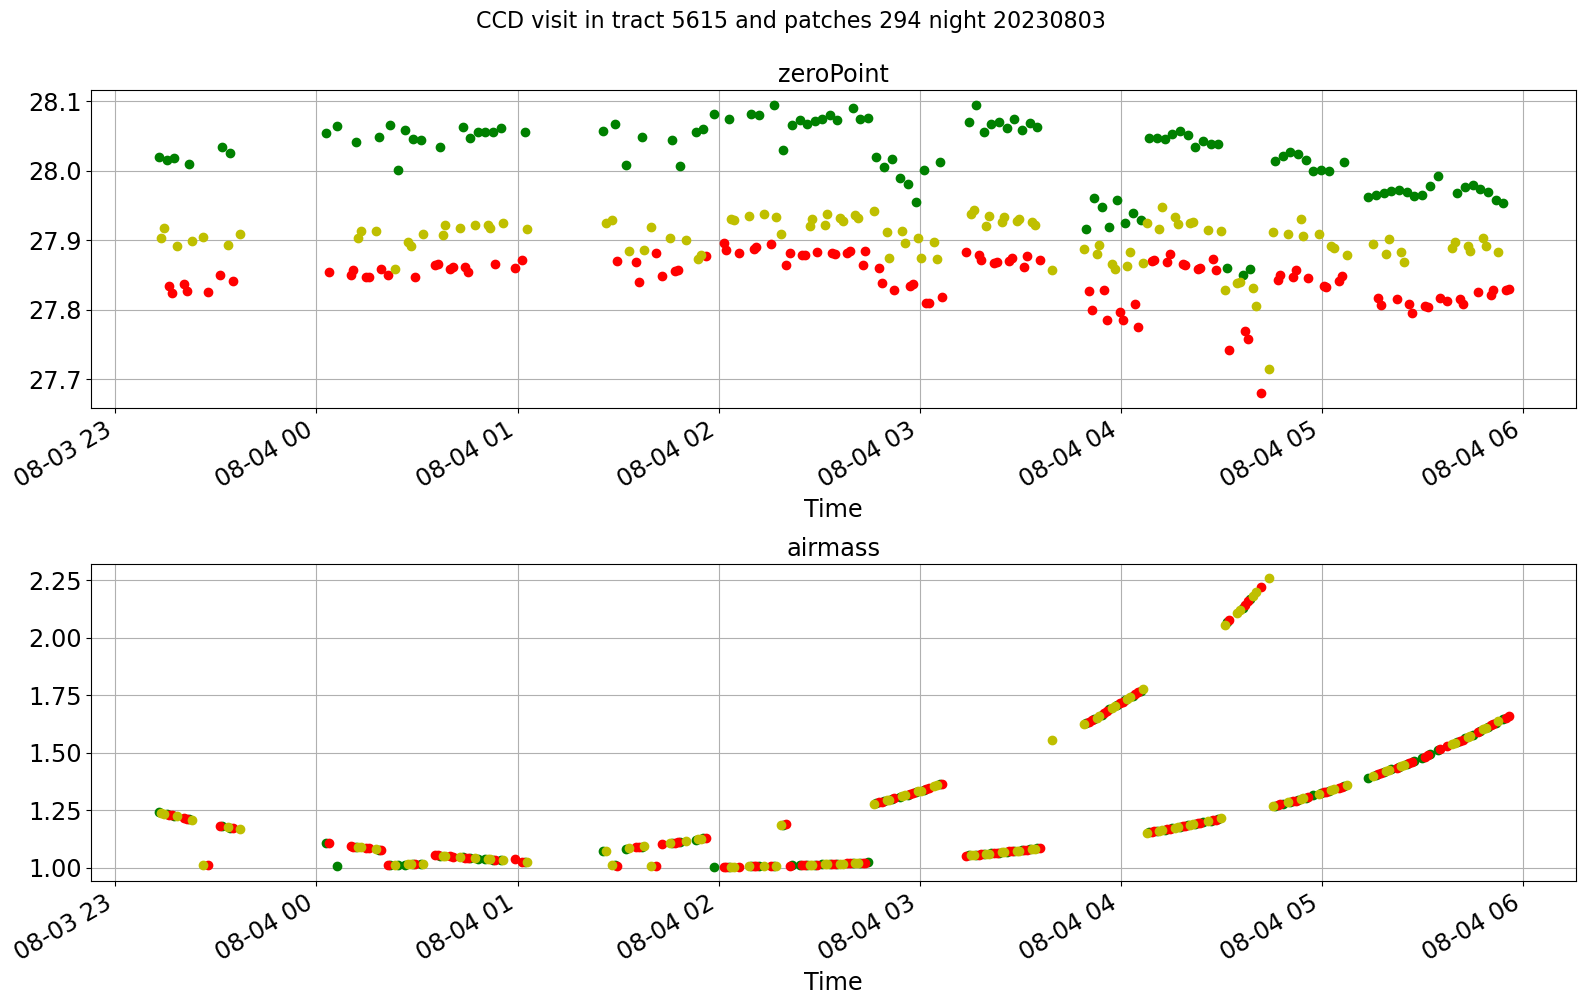

In [63]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(16,10))

df[df["band"]=="g"].plot(x="Time",y="zeroPoint",marker='o',c="g",lw=0.0,ax=ax1,grid=True,legend=False)
df[df["band"]=="r"].plot(x="Time",y="zeroPoint",marker='o',c="r",lw=0.0,ax=ax1,grid=True,legend=False)
df[df["band"]=="i"].plot(x="Time",y="zeroPoint",marker='o',c="y",lw=0.0,ax=ax1,grid=True,legend=False)
ax1.set_title("zeroPoint")

df[df["band"]=="g"].plot(x="Time",y="airmass",marker='o',c="g",lw=0.0,ax=ax2,grid=True,legend=False)
df[df["band"]=="r"].plot(x="Time",y="airmass",marker='o',c="r",lw=0.0,ax=ax2,grid=True,legend=False)
df[df["band"]=="i"].plot(x="Time",y="airmass",marker='o',c="y",lw=0.0,ax=ax2,grid=True,legend=False)
ax2.set_title("airmass")

#df.plot(x="Time",y="coord_dec",marker='o',c="g",lw=0.0,ax=ax2,grid=True)
plt.suptitle(suptitle + f" night {nightObs_selected}",y=1.0,fontsize=16)
plt.tight_layout()

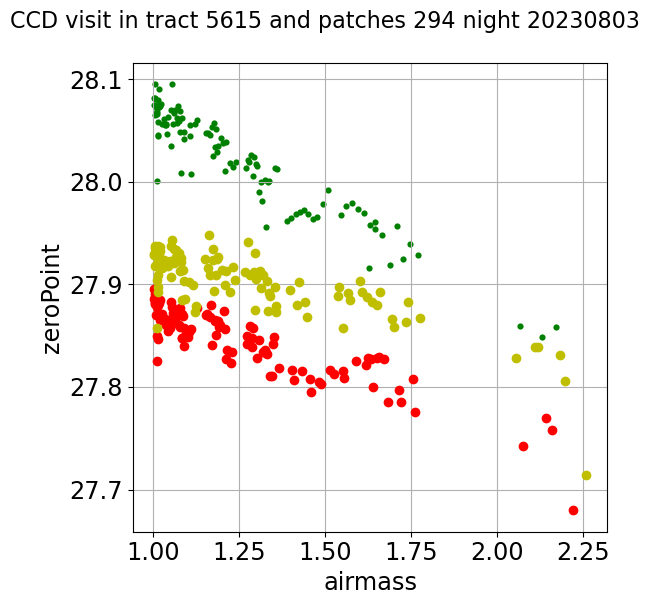

In [64]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

df[df["band"]=="g"].plot.scatter(x="airmass",y="zeroPoint",marker='o',c="g",lw=0.0,ax=ax,grid=True,legend=False)
df[df["band"]=="r"].plot(x="airmass",y="zeroPoint",marker='o',c="r",lw=0.0,ax=ax,grid=True,legend=False)
df[df["band"]=="i"].plot(x="airmass",y="zeroPoint",marker='o',c="y",lw=0.0,ax=ax,grid=True,legend=False)
ax1.set_title("zero point vs airmass")

#df.plot(x="Time",y="coord_dec",marker='o',c="g",lw=0.0,ax=ax2,grid=True)
plt.suptitle(suptitle + f" night {nightObs_selected}",y=1.0,fontsize=16)
plt.tight_layout()

### Plot number of visit per day for patch 313

In [65]:
patches_selected = [313]
suptitle = f"CCD visit in tract {tract_selected} and patches {patches_selected[0]}"

In [66]:
all_patches = []
for patch in tractInfo:
    patchID = patch.getSequentialIndex()
    if patchID in patches_selected:
        all_patches.append(patch)  

In [67]:
ccd_visit_table2 = ccd_visit_table
ccd_visit_table2["selectFlag"] = ccd_visit_table2.apply(SelectVisits, axis=1, raw=False)

In [68]:
ccd_visit_table2["dayobsMJD"]=ccd_visit_table2["obsStartMJD"].apply(np.int64)
ccd_visit_table2['nightObs'] =ccd_visit_table2.apply(lambda x: x['visitId']//100_000, axis=1)

/tmp/ipykernel_8464/308630538.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  ccd_visit_table2.plot.hist(column=["nightObs"], by="band", bins=200,grid=True,ax=ax,legend=False)


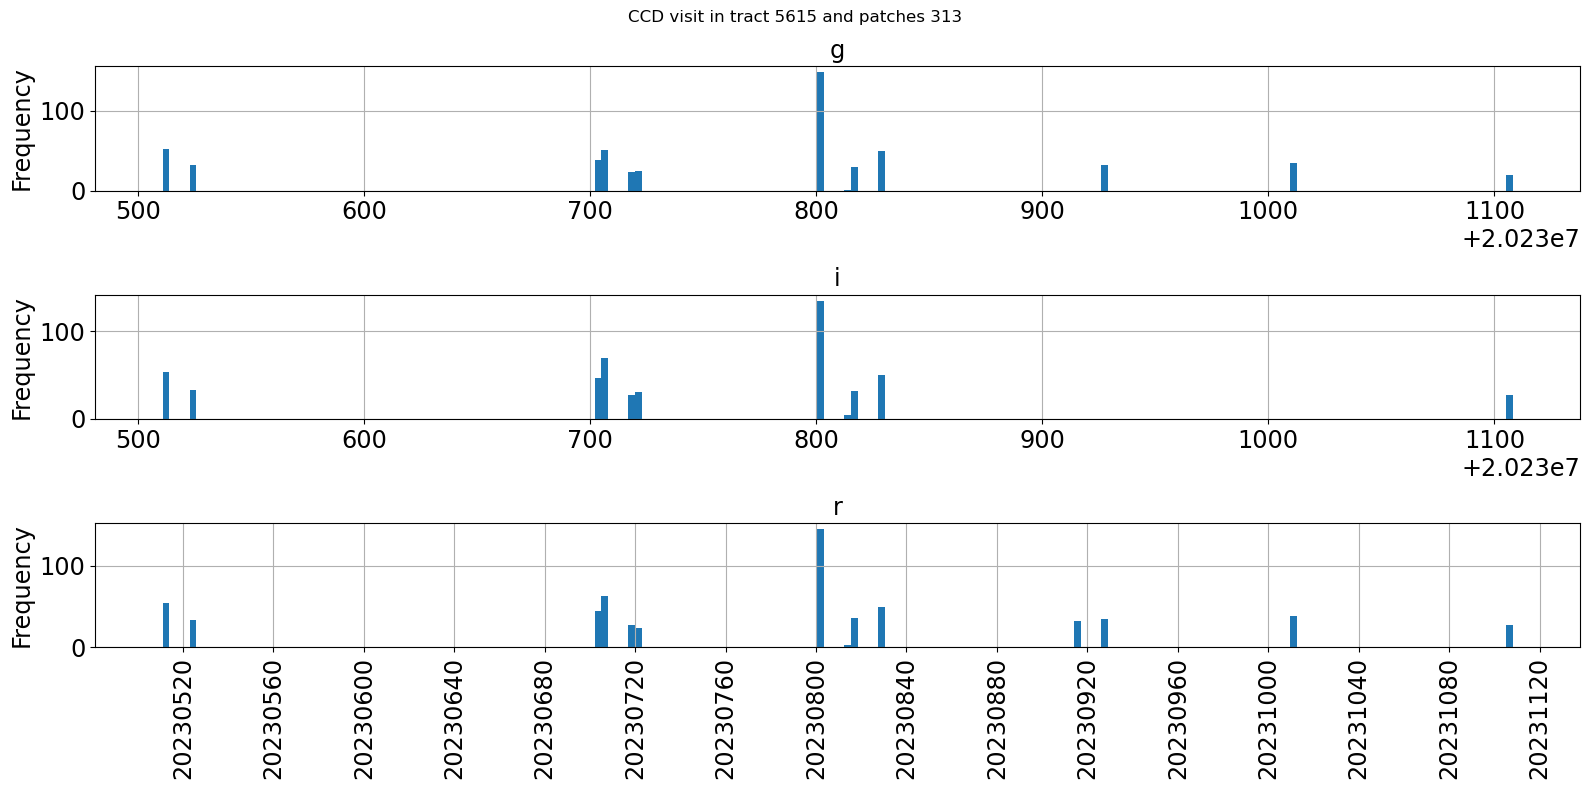

In [69]:
import matplotlib.ticker
fig,ax = plt.subplots(1,1,figsize=(16,8))
ccd_visit_table2.plot.hist(column=["nightObs"], by="band", bins=200,grid=True,ax=ax,legend=False)


# plot x axis as an int
locator = matplotlib.ticker.MultipleLocator(2)

plt.gca().xaxis.set_major_locator(locator)
formatter = matplotlib.ticker.StrMethodFormatter("{x:.0f}")
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
plt.xticks(rotation=90)

plt.suptitle(suptitle)
plt.tight_layout()

In [70]:
ccd_visit_table_counts2 = ccd_visit_table2.groupby(['nightObs','band']).count()["visitId"]
ccd_visit_table_counts2

nightObs  band
20230511  g        52
          i        54
          r        54
20230523  g        13
          i        13
          r        14
20230524  g        19
          i        20
          r        19
20230704  g        17
          i        18
          r        18
20230705  g        21
          i        29
          r        26
20230706  g        51
          i        69
          r        63
20230718  g        23
          i        27
          r        27
20230720  g        24
          i        31
          r        24
20230801  g        14
          i        12
          r        13
20230802  g        22
          i        15
          r        18
20230803  g       112
          i       108
          r       114
20230815  g         1
          i         4
          r         3
20230816  g         4
          i         4
          r         4
20230817  g        26
          i        28
          r        32
20230829  g        50
          i        50
          r      

In [71]:
nightObs_selected = 20230803
ccd_visit_table2_sel = ccd_visit_table1[ccd_visit_table2.nightObs == nightObs_selected]

In [72]:
df = ccd_visit_table2_sel

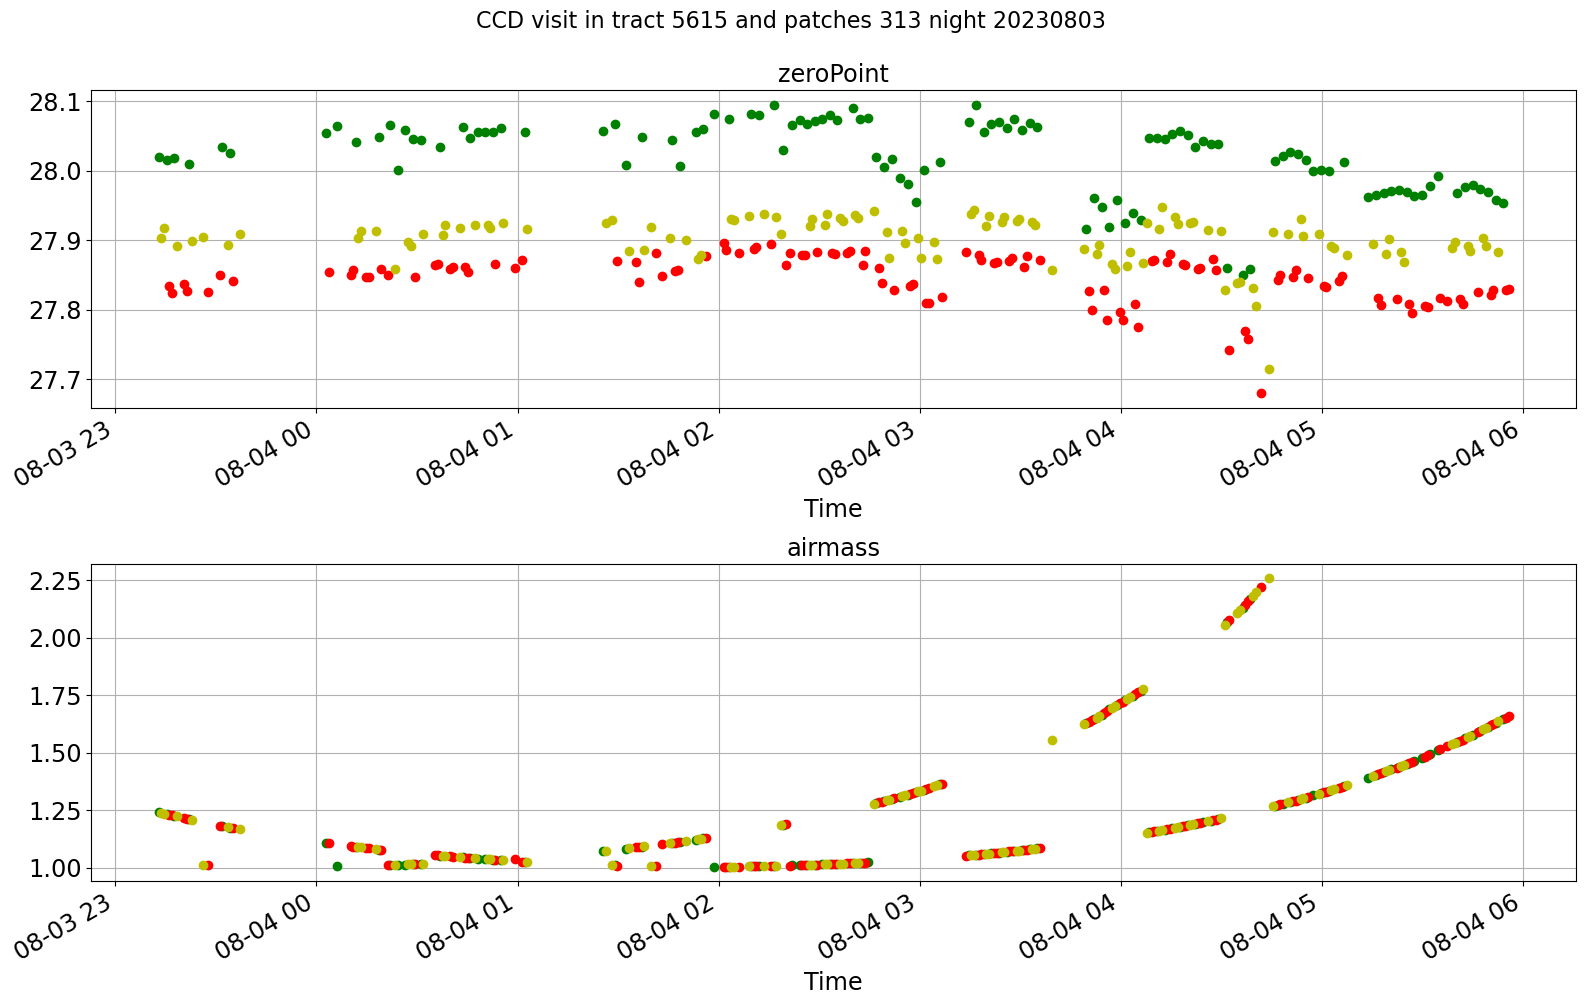

In [73]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(16,10))

df[df["band"]=="g"].plot(x="Time",y="zeroPoint",marker='o',c="g",lw=0.0,ax=ax1,grid=True,legend=False)
df[df["band"]=="r"].plot(x="Time",y="zeroPoint",marker='o',c="r",lw=0.0,ax=ax1,grid=True,legend=False)
df[df["band"]=="i"].plot(x="Time",y="zeroPoint",marker='o',c="y",lw=0.0,ax=ax1,grid=True,legend=False)
ax1.set_title("zeroPoint")

df[df["band"]=="g"].plot(x="Time",y="airmass",marker='o',c="g",lw=0.0,ax=ax2,grid=True,legend=False)
df[df["band"]=="r"].plot(x="Time",y="airmass",marker='o',c="r",lw=0.0,ax=ax2,grid=True,legend=False)
df[df["band"]=="i"].plot(x="Time",y="airmass",marker='o',c="y",lw=0.0,ax=ax2,grid=True,legend=False)
ax2.set_title("airmass")


#df.plot(x="Time",y="coord_dec",marker='o',c="g",lw=0.0,ax=ax2,grid=True)
plt.suptitle(suptitle + f" night {nightObs_selected}",y=1.0,fontsize=16)
plt.tight_layout()

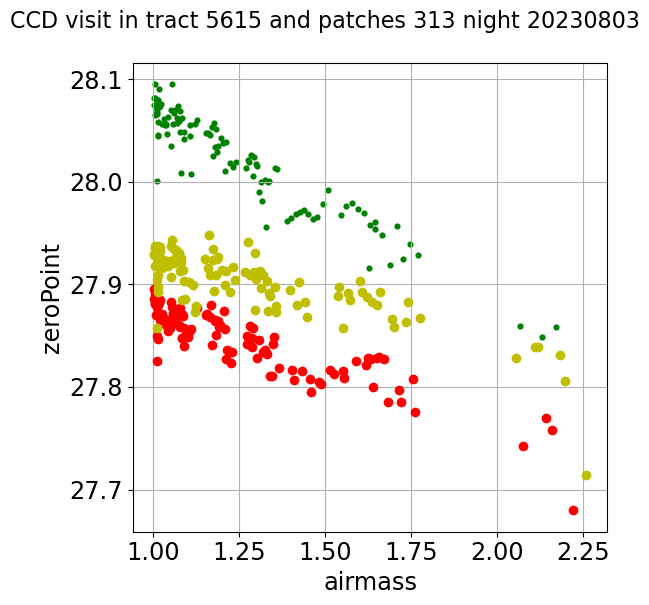

In [74]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

df[df["band"]=="g"].plot.scatter(x="airmass",y="zeroPoint",marker='o',c="g",lw=0.0,ax=ax,grid=True,legend=False)
df[df["band"]=="r"].plot(x="airmass",y="zeroPoint",marker='o',c="r",lw=0.0,ax=ax,grid=True,legend=False)
df[df["band"]=="i"].plot(x="airmass",y="zeroPoint",marker='o',c="y",lw=0.0,ax=ax,grid=True,legend=False)
ax1.set_title("zero point vs airmass")

#df.plot(x="Time",y="coord_dec",marker='o',c="g",lw=0.0,ax=ax2,grid=True)
plt.suptitle(suptitle + f" night {nightObs_selected}",y=1.0,fontsize=16)
plt.tight_layout()